In [37]:
import glob
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.constants as astcont
import astropy.units as u
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

import pysynphot

In [26]:
def load_sky_spectrum(fitsfile, pixscale=0.6, slitwidth=5., zeropoint=48.6):
    """
    Load a Pypeit-reduced 1D sky spectrum and return wavelength in Angstroms and flux in ABmag/arcsec**2

        fitsfile: string - filename of FITS spectrum
        pixscale: float - spatial pixel scale (arcsec/pixel)
        slitwidth: float - width of the slit (arcsec)
        zeropoint: float - zeropoint for AB mag system (AB mag)
    """
    spec = Table.read(fitsfile)
    # we get the calibration function from the ratio of FLAM to COUNTS
    sensfunc = spec['OPT_FLAM'] / spec['OPT_COUNTS']
    # we use the boxcar sky counts to make the extraction pixel area more deterministic
    flux = 1e-17 * sensfunc * spec['BOX_COUNTS_SKY'] / (spec['BOX_NPIX'] * slitwidth * pixscale)  # flam/arcsec**2
    wave = spec['OPT_WAVE']
    spec = pysynphot.ArraySpectrum(wave, flux, fluxunits='flam')
    return spec

In [31]:
sky1 = Table.read("../Sky1.txt", format='ascii', names=['wave', 'abmag'])
sky2 = Table.read("../Sky2.txt", format='ascii', names=['wave', 'abmag'])
massey_blue = pysynphot.ArraySpectrum(sky1['wave'], sky1['abmag'], fluxunits='abmag')
massey_red = pysynphot.ArraySpectrum(sky2['wave'], sky2['abmag'], fluxunits='abmag')

In [115]:
features = Table.read("features.csv")

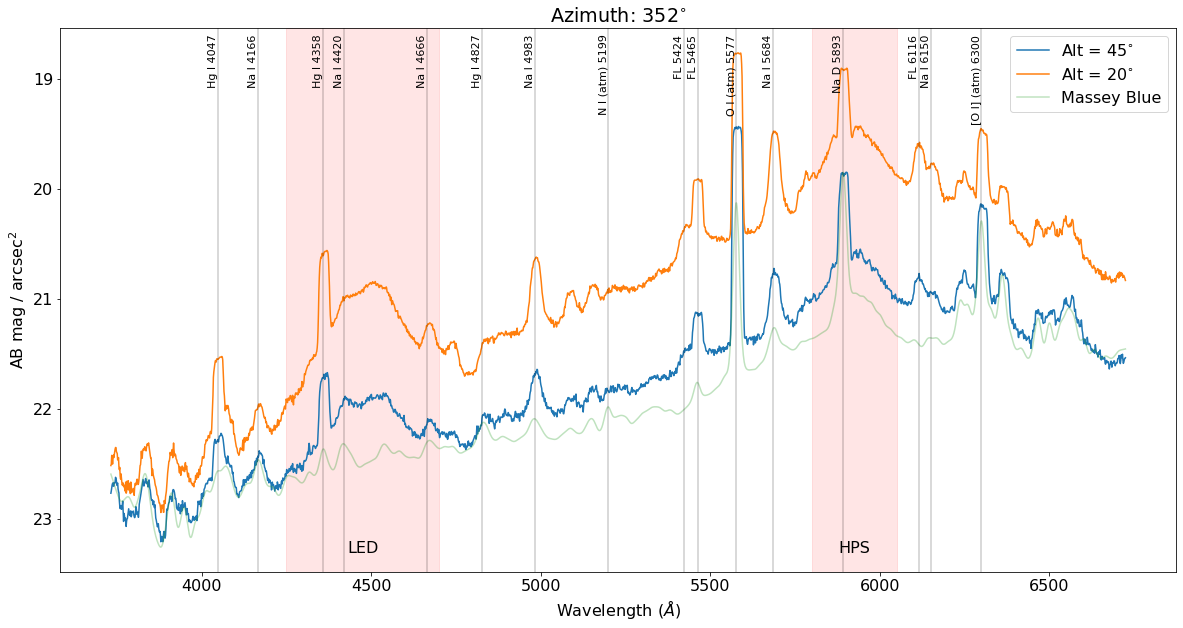

In [116]:
plt.rc('font', size=16)
plt.figure(figsize=[20,10])
tus_el45 = load_sky_spectrum("20191005/pypeit/Science/spec1d_skyobs0036-sky_az352_el45_Blue_Channel_2019Oct06T091809.000.fits")
tus_el20 = load_sky_spectrum("20191005/pypeit/Science/spec1d_skyobs0031-sky_az352_el20_Blue_Channel_2019Oct06T090420.000.fits")
tus_el45.convert('abmag')
tus_el20.convert('abmag')
w = massey_blue.wave
tus_el45_flux = tus_el45.sample(w)
tus_el20_flux = tus_el20.sample(w)
txt_y = 18.6
kernel = Gaussian1DKernel(7)
massey_smooth = convolve(massey_blue.flux.data, kernel, nan_treatment='fill', boundary='extend')
plt.plot(w, tus_el45_flux, label="Alt = 45$^{\circ}$")
plt.plot(w, tus_el20_flux, label="Alt = 20$^{\circ}$")
plt.plot(w, massey_smooth, alpha=0.3, label="Massey Blue")
#plt.plot(massey_red.wave, massey_red.flux, alpha=0.3, label="Massey Red")
plt.gca().invert_yaxis()
plt.xlabel("Wavelength $(\AA)$")
plt.ylabel("AB mag / arcsec$^2$")
plt.title("Azimuth: 352$^{\circ}$")
for f in features:
    if f['low wave'] != f['high wave']:
        plt.axvspan(f['low wave'], f['high wave'], color='r', alpha=0.1)
        txt_x = 0.5*(f['low wave'] + f['high wave'])
        plt.text(txt_x, 23.2, f['name'], horizontalalignment='center', verticalalignment='top')
    else:
        x = f['low wave']
        plt.text(x, txt_y, f"{f['name']} {x}", rotation='vertical', fontsize='x-small', horizontalalignment='right', verticalalignment='top')
        plt.axvline(x, color='black', alpha=0.2)
plt.legend()
plt.savefig("tucson.pdf")
plt.show()

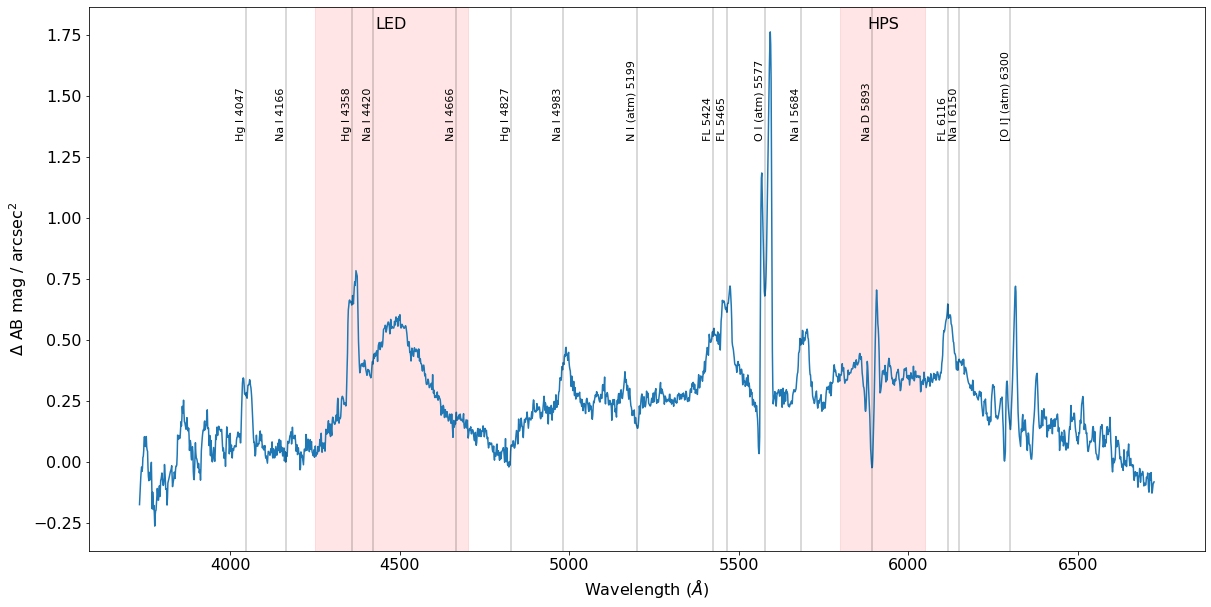

In [117]:
plt.rc('font', size=16)
plt.figure(figsize=[20,10])
diff = massey_smooth-tus_el45_flux
plt.ylabel("AB mag / arcsec$^2$")
plt.plot(w, diff)
txt_y = diff.max()
for f in features:
    if f['low wave'] != f['high wave']:
        plt.axvspan(f['low wave'], f['high wave'], color='r', alpha=0.1)
        txt_x = 0.5*(f['low wave'] + f['high wave'])
        plt.text(txt_x, txt_y, f['name'], horizontalalignment='center', verticalalignment='bottom')
    else:
        x = f['low wave']
        plt.text(x, 0.75*txt_y, f"{f['name']} {x}", rotation='vertical', fontsize='x-small', horizontalalignment='right')
        plt.axvline(x, color='black', alpha=0.2)
plt.xlabel("Wavelength $(\AA)$")
plt.ylabel("$\Delta$ AB mag / arcsec$^2$")
plt.show()

In [55]:
for f in features:
    print(f['name'])

Na D
Hg I
[O I] (atm)
HPS
LED
Na I
O I (atm)
N I (atm)
Na I
Hg I
Na I
Na I
Hg I
Na I
Hg I
